# ABIDE Subtype analysis
The goal of this notebook is to run a subtype analysis on the ABIDE dataset and to look at the subtype weights following Pierre Orban's analysis. Here are the central research questions:

1. What are subtypes of scores maps for different networks (7 network resolution on Cambridge) and how do they look like?
2. What are the individual subject weights for these subtypes (violin plots and Pierre's matrix)
3. For which networks and subtypes is diagnosis a significant predictor of weights?
4. What do weights for these subtypes and networks look like for patients and healthy controls?
5. For which networks and subtypes are dimensional scores like IQ significant predictors of weights?
5. What does the scatterplot of weights over IQ look like?

In [1]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import brainbox as bb
import nilearn as nil
import statsmodels.api as sm
from scipy import stats as st
from matplotlib import gridspec
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from sklearn import linear_model as slin
from statsmodels.sandbox import stats as sts
from matplotlib.colors import LinearSegmentedColormap

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1011: UserWarning: Duplicate key in file "/home/surchs/.config/matplotlib/matplotlibrc", line #405
  (fname, cnt))


In [2]:
%matplotlib inline

# Paths

In [3]:
# Paths
scale = 12
subtypes = 3
network_number = 1
net_id = network_number - 1
mtp = 'stability_maps'
tpl = '*_fmri_{:07d}_session_1_run1_stability_maps.nii.gz'
prior_path = '/data1/cambridge/template/template_cambridge_basc_multiscale_sym_scale012.nii.gz'
data_path = '/data1/abide/Out/Scores/sc{:02d}/time'.format(scale)
#pheno_path = '/data1/abide/Pheno/unconstrained_3box_189_sample.csv'
# unconstrained_3box_276_sample.csv
pheno_path = '/data1/abide/Pheno/nyu_pheno.csv'
mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'
out_path = '/data1/subtypes/sc12'

In [4]:
# Get the mask
m_img = nib.load(mask_path)
mask_data = m_img.get_data()
mask = mask_data != 0

In [5]:
# Get the phenotype data
pheno = pd.read_csv(pheno_path)
# Grab the corresponding file paths - should be sure that they exist
path_list = [glob.glob(os.path.join(data_path, mtp, tpl.format(r['SUB_ID'])))[0] for i, r in pheno.iterrows()]

In [6]:
# Get the prior
p_img = nib.load(prior_path)
prior = p_img.get_data()

# Define some functions and the niak colormap

In [7]:
# Define a new colormap
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 1.0, 1.0),
                   (0.25, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'blue':  ((0.0, 1.0, 1.0),
                   (0.25, 1.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
hotcold = LinearSegmentedColormap('hotcold', cdict)

In [8]:
def show_subtype(net_id, sbt_id, gdavg_img, sbt_store,
                 sbt_store_demeaned, view_mode='x', threshold=0.1, 
                 view_range=[-70,-50, -30, -10, 10, 30, 50, 70]):
    # Show the subtype
    fig = plt.figure(figsize=(24,50))
    gs = gridspec.GridSpec(12, 2, hspace=0.3)

    ax1 = fig.add_subplot(gs[0,0])
    nlp.plot_glass_brain(nil.image.index_img(gdavg_img, net_id), cmap=plt.cm.gnuplot, 
                             axes=ax1, colorbar=False, title='Scores average network {}'.format(net_id+1),
                            vmin=0, vmax=1)

    ax2 = fig.add_subplot(gs[0,1])
    # Turn the vectorized subtype into a volume
    sbt = sbt_store[net_id,sbt_id,:]
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = sbt
    sbt_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
    nlp.plot_glass_brain(sbt_img, cmap=plt.cm.gnuplot, 
                         axes=ax2, colorbar=True, title='Subtype {} network {}'.format(sbt_id+1, net_id+1),
                        vmin=0, vmax=1)
    
    ax3 = fig.add_subplot(gs[1,:])
    # Turn the vectorized demeaned subtype into a volume
    sbt_dm = sbt_store_demeaned[net_id,sbt_id,:]
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = sbt_dm
    sbt_dm_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
    nlp.plot_stat_map(sbt_dm_img, axes=ax3, display_mode=view_mode, threshold=threshold, 
                      cut_coords=view_range, black_bg=True)
    
    return fig

In [9]:
def report_weights(net_id, sbt_id, sub_asd, sub_tdc, weight_store):
    # Look at the weights for subtype 5
    sbt_weights = weight_store[net_id, sbt_id,:]
    # Get the weights for the asd and tdc cases
    asd_weights = sbt_weights[sub_asd]
    tdc_weights = sbt_weights[sub_tdc]
    n_asd = np.sum(sub_asd)
    n_tdc = np.sum(sub_tdc)
    # T-test
    [t,p] = st.ttest_ind(asd_weights, tdc_weights)

    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(121)
    # Indices
    ind_asd = np.ones(n_asd) + (np.random.random(n_asd)*2-1)*0.05
    ind_tdc = np.ones(n_tdc) + (np.random.random(n_tdc)*2-1)*0.05 + 1

    ax1.plot(ind_asd, asd_weights, 'k.')
    ax1.plot(ind_tdc, tdc_weights, 'k.')
    ax1.boxplot([asd_weights, tdc_weights])
    ax1.set_xticklabels(['ASD', 'TDC'], rotation=60)
    ax1.set_ylabel('weights')

    ax2 = fig.add_subplot(122)
    tmp = ax2.violinplot([asd_weights, tdc_weights])
    ax2.set_xticks([1,2])
    ax2.set_xticklabels(['ASD', 'TDC'], rotation=60)

    fig.suptitle('T-Test: T {:.2f}, p {:.4f}'.format(t,p))
    return fig

## Build the subtypes and compute the weights

In [10]:
# Run over all subtypes and networks
scale = 12
subtypes = 5
n_vox = np.sum(mask)
n_files = len(path_list)
# Let's run the model again for all networks and subtypes
gdavg = np.zeros(mask.shape + (scale,))
pval_store = np.zeros((scale, subtypes))
weight_store = np.zeros((scale, subtypes, n_files))
sbt_store = np.zeros((scale, subtypes, n_vox))
sbt_store_2 = np.zeros((scale, subtypes, n_vox))
corr_store = np.zeros((n_files, n_files, scale))
link_store = np.zeros((n_files-1,4,scale))
part_store = np.zeros((scale, n_files))

timer = bb.tools.Counter(scale)
for net_id in range(scale):
    timer.tic()
    # Get the scores maps into a voxel by subject array
    # Init store
    net_stack = np.zeros((n_vox, n_files))
    # Iterate files
    for index, s_path in enumerate(path_list):
        # Getting data
        f_net = nib.load(s_path).get_data()[mask][..., net_id]
        net_stack[..., index] = f_net
    
    grand_average = np.reshape(np.mean(net_stack, 1), (net_stack.shape[0], 1))
    # Save a copy of the non-demeanded subtypes
    net_stack_2 = np.copy(net_stack)
    # Demean the net stack
    net_stack = net_stack - grand_average
    # Save the grand average
    tmpl = np.zeros_like(mask, dtype=np.float16)
    tmpl[mask] = grand_average[:, 0]
    gdavg[..., net_id] = tmpl
    
    # Build correlation matrix on the network stack
    corr_mat = np.corrcoef(net_stack, rowvar=0)
    # Compute linkage with Ward's criterion
    link_mat = scl.hierarchy.linkage(corr_mat, method='ward')
    # Store both
    corr_store[..., net_id] = corr_mat
    link_store[..., net_id] = link_mat
    # Partition the linkage to get a given number of subtypes
    part_sub = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')
    part_store[net_id, :] = part_sub
    
    # Init store - Build subtypes
    sub_stack = np.zeros((n_vox, subtypes))
    for s_id in range(subtypes):
        sbt = np.mean(net_stack[:, part_sub==s_id+1],1)
        sub_stack[:,s_id] = sbt
        sbt_store[net_id, s_id, :] = sbt
        
    # Make the non-demeaned subtypes
    for s_id in range(subtypes):
        sbt = np.mean(net_stack_2[:, part_store[net_id, :]==s_id+1],1)
        sbt_store_2[net_id, s_id, :] = sbt

    # Init store - Compute the weights
    for s_id in range(subtypes):
        type_map = sub_stack[:, s_id]
        weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, net_stack[:,x])[0,1] for x in range(n_files)])

    timer.toc()
    timer.progress()

 100.0 % done 0.00 seconds to go. One step takes 16.88827 and we ran for 219.55 s so far

In [207]:
# Reduce the phenotype data to those subjects 
# that actually have the covariate of interest
cov_list = ['FIQ', 'EYE_STATUS_AT_SCAN', 'SCQ_TOTAL', 'ADOS_TOTAL', 'ADI_R_SOCIAL_TOTAL_A',
            'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 'ADI_R_ONSET_TOTAL_D']
cov = 'EYE_STATUS_AT_SCAN'
cov_index = pd.notnull(pheno.replace(-9999, np.nan)[cov])

In [208]:
len(cov_index)

184

In [209]:
np.sum(~cov_index)

0

In [210]:
cov_pheno = pheno[cov_index]

In [211]:
cov_pheno.columns

Index([u'Unnamed: 0', u'SITE_ID', u'SUB_ID', u'DX_GROUP', u'DSM_IV_TR',
       u'AGE_AT_SCAN', u'SEX', u'HANDEDNESS_CATEGORY', u'HANDEDNESS_SCORES',
       u'FIQ', u'VIQ', u'PIQ', u'FIQ_TEST_TYPE', u'VIQ_TEST_TYPE',
       u'PIQ_TEST_TYPE', u'ADI_R_SOCIAL_TOTAL_A', u'ADI_R_VERBAL_TOTAL_BV',
       u'ADI_RRB_TOTAL_C', u'ADI_R_ONSET_TOTAL_D', u'ADI_R_RSRCH_RELIABLE',
       u'ADOS_MODULE', u'ADOS_TOTAL', u'ADOS_COMM', u'ADOS_SOCIAL',
       u'ADOS_STEREO_BEHAV', u'ADOS_RSRCH_RELIABLE', u'ADOS_GOTHAM_SOCAFFECT',
       u'ADOS_GOTHAM_RRB', u'ADOS_GOTHAM_TOTAL', u'ADOS_GOTHAM_SEVERITY',
       u'SRS_VERSION', u'SRS_RAW_TOTAL', u'SRS_AWARENESS', u'SRS_COGNITION',
       u'SRS_COMMUNICATION', u'SRS_MOTIVATION', u'SRS_MANNERISMS',
       u'SCQ_TOTAL', u'AQ_TOTAL', u'COMORBIDITY', u'CURRENT_MED_STATUS',
       u'MEDICATION_NAME', u'OFF_STIMULANTS_AT_SCAN',
       u'VINELAND_RECEPTIVE_V_SCALED', u'VINELAND_EXPRESSIVE_V_SCALED',
       u'VINELAND_WRITTEN_V_SCALED', u'VINELAND_COMMUNICATION_STANDA

In [212]:
cov_weight = weight_store[..., cov_index.values]

In [213]:
cov_weight.shape

(12, 5, 184)

In [214]:
# Generate the model matrix
factors = [cov, 'SEX', 'AGE_AT_SCAN', 'FD_scrubbed']
# Make dummy variables for the site factor
site_factor = pd.get_dummies(cov_pheno['SITE_ID'])
# Turn the first site into the intercept
site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
site_factor['INTERCEPT'] = 1
# Get the other variables
other_factors = cov_pheno.ix[:,factors]
# Turn diagnosis into [0,1] vector
#other_factors['DX_GROUP'] = other_factors['DX_GROUP'].values - 1
# Demean age
other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
# Put them back together
glm_pheno = pd.concat([site_factor, other_factors], axis=1)

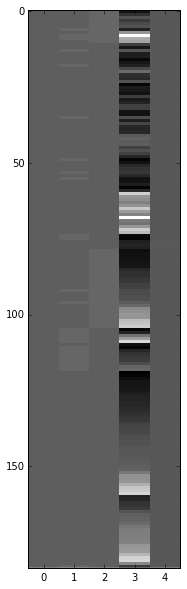

In [215]:
fig = plt.figure(figsize=(4,10))
ax = fig.add_subplot(111)
ax.imshow(glm_pheno, aspect=0.1, interpolation='None', cmap=plt.cm.Greys_r)

In [216]:
res_store = list()
pval_store = np.zeros((scale, subtypes))
for net_id in range(scale):
    res_list = list()
    # Loop through the subtypes
    for s_id in range(subtypes):
        model = sm.OLS(cov_weight[net_id, s_id, :], glm_pheno)
        results = model.fit()
        # Save the p-values
        pval_store[net_id, s_id] = results.pvalues[cov]
        res_list.append(results)
    res_store.append(res_list)

# Look at the results

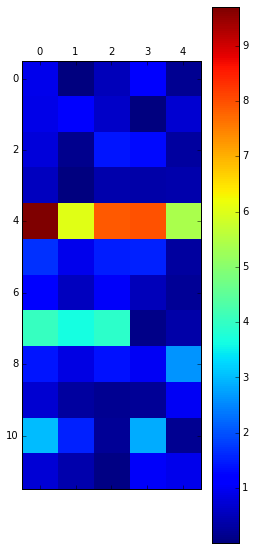

In [217]:
# Look at the uncorrected p-values for the GLM with diagnosis across networks
tmp = plt.matshow(-np.log10(pval_store))
tmp = plt.colorbar()

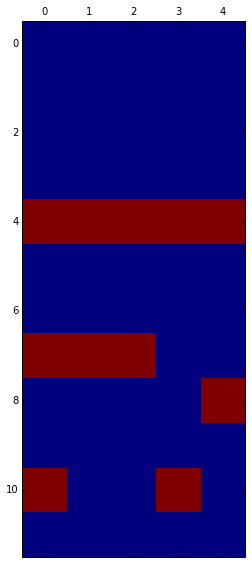

In [218]:
# Now look at the mask of p-values passing FDR Correction
pval_vec = np.reshape(pval_store, np.prod(pval_store.shape))
pcorr_vec = sts.multicomp.fdrcorrection0(pval_vec, 0.05)
pcorr_store = np.reshape(pcorr_vec[0], pval_store.shape)
tmp = plt.matshow(pcorr_store)

In [199]:
print(res_store[1][3].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     10.67
Date:                Tue, 29 Sep 2015   Prob (F-statistic):           1.34e-07
Time:                        04:15:56   Log-Likelihood:                 123.04
No. Observations:                 149   AIC:                            -236.1
Df Residuals:                     144   BIC:                            -221.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
INTERCEPT         0.0020      0.049      0.041

In [200]:
# Find the subjects that are ASD (1) and controls (2)
sub_asd = pheno['DX_GROUP'].values == 1
sub_tdc = pheno['DX_GROUP'].values == 2

In [201]:
# Find the p-values passing FDR (from the above mask)
np.argwhere(pcorr_store)

array([[1, 3]])

Note that the numpy array is zero-indexed.

At scale 12 with 5 subtypes I find 3 results passing FDR. Those are:

1. Network 2 and subtype 5
2. Network 4 and subtype 4
3. Network 5 and subtype 3

Let's take a closer look at these networks

## Overview of subtypes across all networks

In [202]:
# Turn the grand average into an image
gdavg_img = nib.Nifti1Image(gdavg, affine=m_img.get_affine(), header=m_img.get_header())

In [203]:
# Turn the priors into an image
prior = nib.load(prior_path)
prior_data = prior.get_data()
prior_temp = np.zeros((prior_data.shape + (scale,)))
for sc_id in range(scale):
    tmp = np.zeros_like(prior_data)
    tmp[prior_data==sc_id+1] = sc_id + 1
    prior_temp[..., sc_id] = tmp
prior_img = nib.Nifti1Image(prior_temp, affine=m_img.get_affine(), header=m_img.get_header())

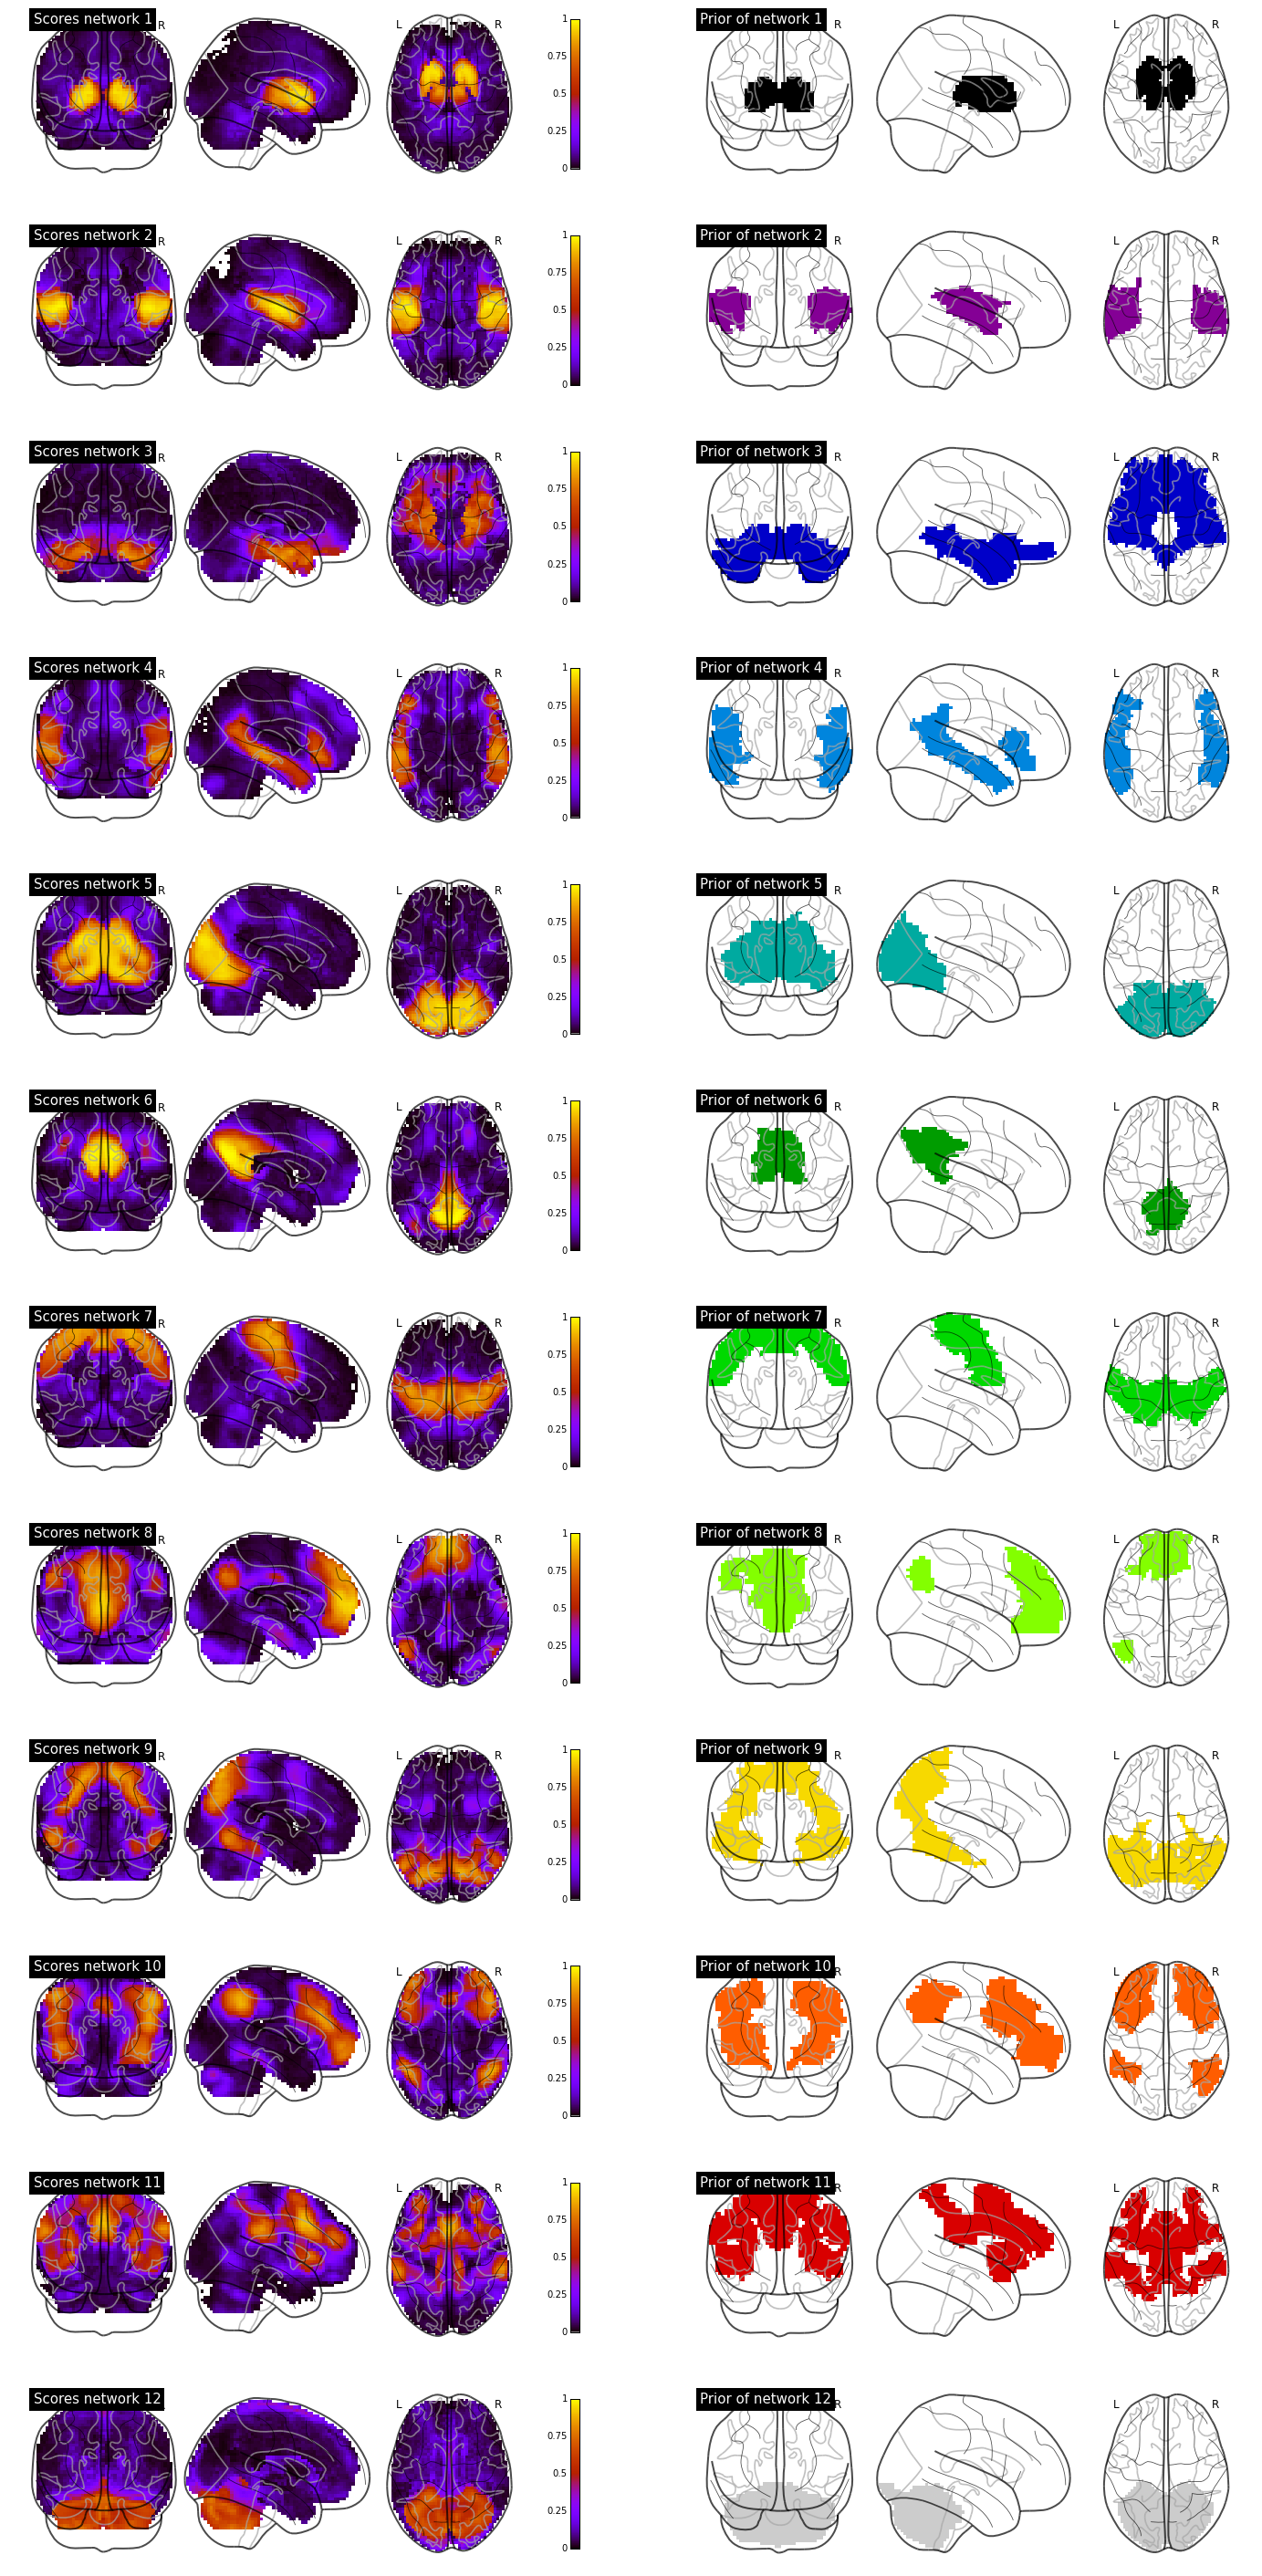

In [204]:
fig = plt.figure(figsize=(24,50))
gs = gridspec.GridSpec(12, 2, hspace=0.3)
for s_id in np.arange(0,12):
    ax1 = fig.add_subplot(gs[s_id,0])
    nlp.plot_glass_brain(nil.image.index_img(gdavg_img,s_id), cmap=plt.cm.gnuplot, 
                         axes=ax1, colorbar=True, title='Scores network {}'.format(s_id+1),
                        vmin=0, vmax=1)
    ax2 = fig.add_subplot(gs[s_id,1])
    nlp.plot_glass_brain(nil.image.index_img(prior_img,s_id), cmap=plt.cm.spectral, 
                         axes=ax2, colorbar=False, title='Prior of network {}'.format(s_id+1),
                        vmin=1, vmax=12)

## Network 2

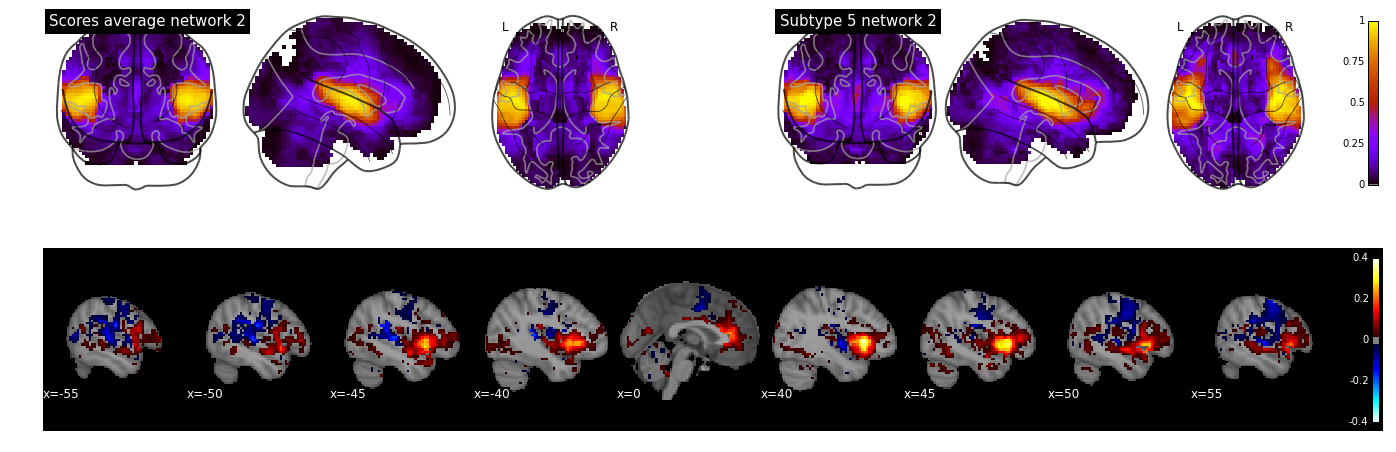

In [219]:
# vr = np.concatenate((np.arange(-55,-35,5), np.arange(40,55,5)))
vr = np.array([-55,-50,-45,-40,0,40,45,50,55])
fig_n2_sbt_5 = show_subtype(1, 4, gdavg_img, sbt_store_2, sbt_store, threshold=0.02, view_range=vr, view_mode='x')

The subtype shows a hotspot of __above average__ stability in the __supramarginal gyrus__, close to the __temporo-parietal junction__. By contrast, __below average__ stability is most prominently located near bilateral __insular cortices__ as well as in the __anterior cingulate cortex__. 

In [ ]:
# Look at the results of the GLM for this subtype
print(res_store[1][4].summary())

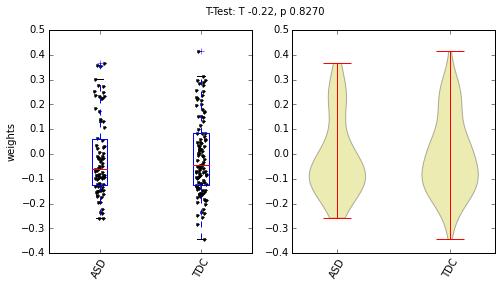

In [206]:
fig_net_2_sbt_5_weights = report_weights(1, 4, sub_asd, sub_tdc, weight_store)

Short summary

* positive T-value
* weights on average lower for ASD
* subtype shows above average stability close to TPJ
* subjects more similar to this subtype are more likely to be TDC than ASD

# Network 4

In [ ]:
vr = np.concatenate((np.arange(-60,-40,5), np.arange(45,65,5)))
fig_n4_sbt_4 = show_subtype(3, 3, gdavg_img, sbt_store_2, sbt_store, threshold=0.03, view_range=vr, view_mode='x')

___Above average___ stability is localized predominantly in the __left middle temporal gyrus__. Interestingly, the pattern of above average stability is bound dorsally by ___below average___ stability in the __superior temporal gyrus__ extending rostral to the __bilateral poles of the temporal lobe__. Another hotspot of below average stability can be found near the __right supramarginal/angular gyrus__.

In [ ]:
# Look at the results of the GLM for this subtype
print(res_store[3][3].summary())

In [ ]:
fig_net_4_sbt_4_weights = report_weights(3, 3, sub_asd, sub_tdc, weight_store)

Short summary

* positive T-value
* weights on average lower for ASD
* subtype shows above average stability close to TPJ
* subjects more similar to this subtype are more likely to be TDC than ASD

## Network 5

In [ ]:
vr = np.concatenate((np.arange(-40,0,10), np.arange(10,50,10)))
fig_n5_sbt_3 = show_subtype(4, 2, gdavg_img, sbt_store_2, sbt_store, view_mode='x', view_range=vr, threshold=0.03)

Clear hotspot of ___below average___ stability in bilateral __poles of the occipital cortex__. This is surrounded rostrally by another clear area of ___above average___ stability that ends abruptly at the __parieto-occipital fissure__.

In [ ]:
# Look at the results of the GLM for this subtype
print(res_store[4][2].summary())

In [ ]:
fig_net_5_sbt_3_weights = report_weights(4, 2, sub_asd, sub_tdc, weight_store)

A negative T value in the GLM indicates that lower weights of subtype 3 are associated with a higher probability of being TDC than ASD. This is also evident from looking at the weight distributions between ASD and TDC shown above.